In [21]:
import numpy as np
from functools import partial
from collections import defaultdict, Counter

In [34]:
def entropy(class_probs):
    """При заданном списке вероятностей вычислить энтропию"""
    return sum(-p * np.math.log(p, 2) 
               for p in class_probs
               if p) # Игнорируем нулевые вероятности

In [24]:
def class_probs(labels):  # labels - выходы
    """При заданном списке выходных классов вычислить пропорции классов"""
    total_count = len(labels)
    return [count / total_count 
            for count in Counter(labels).values()]

In [25]:
def data_entropy(labeled_data):
    """Имея обучающую выбору в формате (X, y) вычислить энтропию"""
    labels = [label for _, label in labeled_data]
    probs = class_probs(labels)
    return entropy(probs)

In [26]:
def partition_entropy(subsets):
    """Найти энтропию разбиения данных на подгруппы, подгруппа - подмножество маркированных данных"""
    total_count = sum(len(subset) for subset in subsets)
    return sum(len(subset) / total_count * data_entropy(subset)
               for subset in subsets)

In [7]:
data = [
    ({'level': 'Senior', 'lang': 'Java', 'tweets': 'no', 'phd': 'no'}, False),
    ({'level': 'Senior', 'lang': 'Java', 'tweets': 'no', 'phd': 'yes'}, False),
    ({'level': 'Mid', 'lang': 'Python', 'tweets': 'no', 'phd': 'no'}, True),
    ({'level': 'Junior', 'lang': 'Python', 'tweets': 'no', 'phd': 'no'}, True),
    ({'level': 'Junior', 'lang': 'R', 'tweets': 'yes', 'phd': 'no'}, True),
    ({'level': 'Junior', 'lang': 'R', 'tweets': 'yes', 'phd': 'yes'}, False),
    ({'level': 'Mid', 'lang': 'R', 'tweets': 'yes', 'phd': 'yes'}, True),
    ({'level': 'Senior', 'lang': 'Python', 'tweets': 'no', 'phd': 'no'}, False),
    ({'level': 'Senior', 'lang': 'R', 'tweets': 'yes', 'phd': 'no'}, True),
    ({'level': 'Junior', 'lang': 'Python', 'tweets': 'yes', 'phd': 'no'}, True),
    ({'level': 'Senior', 'lang': 'Python', 'tweets': 'yes', 'phd': 'yes'}, True),
    ({'level': 'Mid', 'lang': 'Python', 'tweets': 'no', 'phd': 'yes'}, True),
    ({'level': 'Mid', 'lang': 'Java', 'tweets': 'yes', 'phd': 'no'}, True),
    ({'level': 'Junior', 'lang': 'Python', 'tweets': 'no', 'phd': 'yes'}, False)
]

In [8]:
# ID3 algorithm (greedy)
# 1. Если все данные имеют одинаковую метку, то создать листовой узел, который предсказывает эту метку,
#    и остановиться
# 2. Если список атрибутов пуст (т.е. больше вопросов не осталось), то создать листовой узел, который предсказывает
#    наиболее общую метку, и затем остановиться
# 3. В противном случае попытаться разбить данные по каждому атрибуту
# 4. Выбрать разбиение с наименьшей энтропией
# 5. Добавить решающий узел на основе выбранного атрибута
# 6. Рекурсивно повторить для каждой подгруппы, получившейся в результате разбиения, используя оставшиеся атрибуты

In [9]:
def partition_by(attribute, data):
    """data - данные в формате выше,
       возвращает словарь, где ключ = значения атрибута, значение = подмножество inputs"""
    groups = defaultdict(list)
    for d in data:
        key = d[0][attribute]
        groups[key].append(d)
    return groups

In [10]:
def partition_entropy_by(attribute, data):
    """Вычисляет энтропию, соответствующую разбиению по заданному атрибуту"""
    subsets = partition_by(attribute, data).values()
    return partition_entropy(subsets)

In [11]:
# Соберем все вместе, элементы дерева:
# True/False - листовой узел, возвращающий истину/ложь
# Кортеж (attribute, subtree_tuple) - решающий узел

In [47]:
class ID3DecisionTree:

    
    def build_tree(self, data, split_attributes=None):
        # Если атрибуты для разбиения не предоставили, выбираем все возможные
        if split_attributes is None:
            split_attributes = data[0][0].keys()
        
        data_count = len(data)
        true_data_count = len([label for _, label in data if label])
        false_data_count = data_count - true_data_count
        
        # Если все метки одинаковы, то возвращаем соответствующий лист
        if true_data_count == 0: return False
        if false_data_count == 0: return True
        
        # Если атрибуты для разбиения закончились, выбираем наиболее общую метку
        if not split_attributes:
            return true_data_count >= false_data_count
        
        # Выбираем аттрибут с минимальной энтропией разбиения
        best_attribute = min(split_attributes, key=partial(partition_entropy_by, data=data))
        
        # Считаем разбиения по значениям лучшего атрибута
        partitions = partition_by(best_attribute, data)
        
        # Пересчитываем атрибуты для разбиения (нельзя разбить по одному атрибуту дважды)
        new_split_attributes = [a for a in split_attributes if a != best_attribute]
        
        # Рекурсивно подсчитываем поддеревья по значением разбивающего атрибута
        subtrees = {attribute_value: self.build_tree(subset, new_split_attributes)
                    for attribute_value, subset in partitions.items()}
        
        # В случае если встретилось неожиданное значение атрибута, выбираем наиболее общую метку
        subtrees[None] = true_data_count >= false_data_count
        
        return (best_attribute, subtrees)
        
    
    def fit(self, data):
        """Обучить модель на маркированных данных"""
        self.tree = self.build_tree(data)
        
        
    def predict(self, X, tree=None):
        """Классифицировать маркированные данные"""
        
        # Если дерево не передали в аргументе, используем самое общее дерево
        if tree is None:
            tree = self.tree
        
        # Если дерево - листовой узел, вернуть его
        if tree in [False, True]:
            return tree
        
        # Иначе дерево состоит из расщепляющего атрибута
        # и словаря, где ключи - значения этого атрибута, а
        # значения - это поддеревья, подлежащие рассмотрению в следующую очередь
        split_attribute, tree_partition = tree
        
        # Берем из входа значение разделяющего атрибута
        split_attribute_value = X.get(split_attribute)
    
        # Если значение атрибута не известно построенному дереву, то используем None => выбирает наиболее общую метку
        if split_attribute_value not in tree_partition.keys():
            split_attribute_value = None
            
        # Выбираем подходящее входным данным поддерево
        subtree = tree_partition[split_attribute_value]
        
        # Повторяем функцию рекурсивно, пока не дойдем до листа (наш ответ)
        return self.predict(X, tree=subtree)

In [48]:
# Тест

clf = ID3DecisionTree()
clf.fit(data)

In [50]:
X_true = {'level': 'Junior', 'lang': 'Java', 'tweets': 'yes', 'phd': 'no'}
X_false = {'level': 'Junior', 'lang': 'Java', 'tweets': 'yes', 'phd': 'yes'}
print(clf.predict(X_true), clf.predict(X_false))

True False


In [51]:
clf.tree

('level',
 {'Senior': ('tweets', {'no': False, 'yes': True, None: False}),
  'Mid': True,
  'Junior': ('phd', {'no': True, 'yes': False, None: True}),
  None: True})

In [72]:
# Воспользуемся проверенным решением
from sklearn.datasets import load_iris
from sklearn import tree

iris = load_iris()
X, y = iris.data, iris.target

clf = tree.DecisionTreeClassifier()
clf = clf.fit(X, y)

[Text(167.4, 199.32, 'X[2] <= 2.45\ngini = 0.667\nsamples = 150\nvalue = [50, 50, 50]'),
 Text(141.64615384615385, 163.07999999999998, 'gini = 0.0\nsamples = 50\nvalue = [50, 0, 0]'),
 Text(193.15384615384616, 163.07999999999998, 'X[3] <= 1.75\ngini = 0.5\nsamples = 100\nvalue = [0, 50, 50]'),
 Text(103.01538461538462, 126.83999999999999, 'X[2] <= 4.95\ngini = 0.168\nsamples = 54\nvalue = [0, 49, 5]'),
 Text(51.50769230769231, 90.6, 'X[3] <= 1.65\ngini = 0.041\nsamples = 48\nvalue = [0, 47, 1]'),
 Text(25.753846153846155, 54.359999999999985, 'gini = 0.0\nsamples = 47\nvalue = [0, 47, 0]'),
 Text(77.26153846153846, 54.359999999999985, 'gini = 0.0\nsamples = 1\nvalue = [0, 0, 1]'),
 Text(154.52307692307693, 90.6, 'X[3] <= 1.55\ngini = 0.444\nsamples = 6\nvalue = [0, 2, 4]'),
 Text(128.76923076923077, 54.359999999999985, 'gini = 0.0\nsamples = 3\nvalue = [0, 0, 3]'),
 Text(180.27692307692308, 54.359999999999985, 'X[0] <= 6.95\ngini = 0.444\nsamples = 3\nvalue = [0, 2, 1]'),
 Text(154.5230

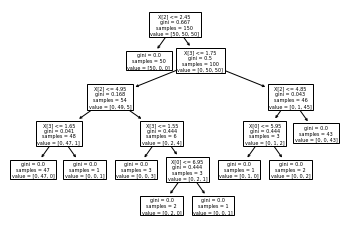

In [73]:
tree.plot_tree(clf) 

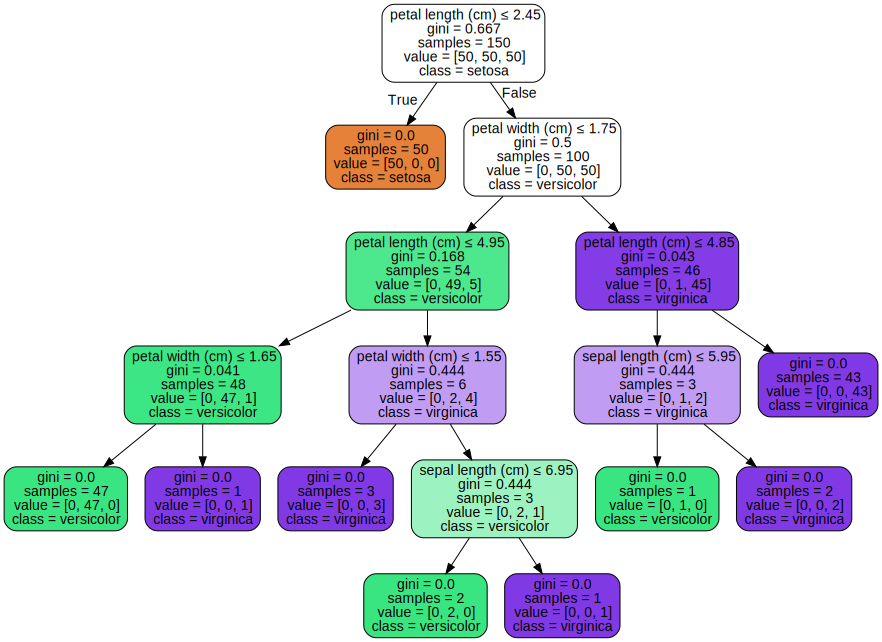

In [74]:
import graphviz

dot_data = tree.export_graphviz(clf, out_file=None, 
                                feature_names=iris.feature_names,  
                                class_names=iris.target_names,  
                                filled=True, rounded=True,  
                                special_characters=True) 
graph = graphviz.Source(dot_data) 
graph